# Demographic Breakdown in MENAAP

## Data Source

**Age Breakdown Data**: United Nations World Population Prospects 2024

- **Source**: [United Nations, Department of Economic and Social Affairs, Population Division](https://population.un.org/wpp/)
- **File**: POP/02-1 - Total population (both sexes combined) by five-year age group, region, subregion and country, annually for 1950-2100 (thousands)
- **Period**: Estimates for 1950-2023
- **License**: © July 2024 by United Nations, made available under a Creative Commons license CC BY 3.0 IGO
- **URL**: http://creativecommons.org/licenses/by/3.0/igo/

**Suggested Citation**: United Nations, Department of Economic and Social Affairs, Population Division (2024). World Population Prospects 2024, Online Edition.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from wbpyplot import wb_plot

In [43]:
wb_regions = pd.read_csv('../../../ssarva/MENAAP-Conflict-Analysis/data/worldbank_regions_iso3_exclusions.csv')

In [44]:
country_mapping = wb_regions[['country_code', 'country_name']].drop_duplicates().set_index('country_code').to_dict()['country_name']

In [19]:
df = pd.read_excel('../data/age_breakdown.xlsx')

In [45]:
df.columns

Index(['Index', 'Variant', 'Region, subregion, country or area *', 'Notes',
       'Location code', 'ISO3 Alpha-code', 'ISO2 Alpha-code', 'SDMX code**',
       'Type', 'Parent code', 'Year', '0-4', '5-9', '10-14', '15-19', '20-24',
       '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64',
       '65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99', '100+'],
      dtype='object')

In [47]:
df['country_name'] = df['ISO3 Alpha-code'].map(country_mapping)

In [48]:
ages = ['0-4', '5-9', '10-14', '15-19', '20-24',
       '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64',
       '65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99', '100+']

In [49]:

# Group age buckets into 10-year intervals
age_mapping = {
    '0-4': '0-9',
    '5-9': '0-9',
    '10-14': '10-19',
    '15-19': '10-19',
    '20-24': '20-29',
    '25-29': '20-29',
    '30-34': '30-39',
    '35-39': '30-39',
    '40-44': '40-49',
    '45-49': '40-49',
    '50-54': '50-59',
    '55-59': '50-59',
    '60-64': '60-69',
    '65-69': '60-69',
    '70-74': '70-79',
    '75-79': '70-79',
    '80-84': '80+',
    '85-89': '80+',
    '90-94': '80+',
    '95-99': '80+',
    '100+': '80+'
}

# Create new dataframe with 10-year age groups
age_groups_10yr = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']

# Sum the population for each 10-year age group
df_grouped = df.copy()
for age_group in age_groups_10yr:
    columns_to_sum = [col for col, mapped in age_mapping.items() if mapped == age_group]
    df_grouped[age_group] = df[columns_to_sum].sum(axis=1)

# Keep only necessary columns
country_col = 'country_name'
df_grouped = df_grouped[[country_col, 'ISO3 Alpha-code'] + age_groups_10yr]


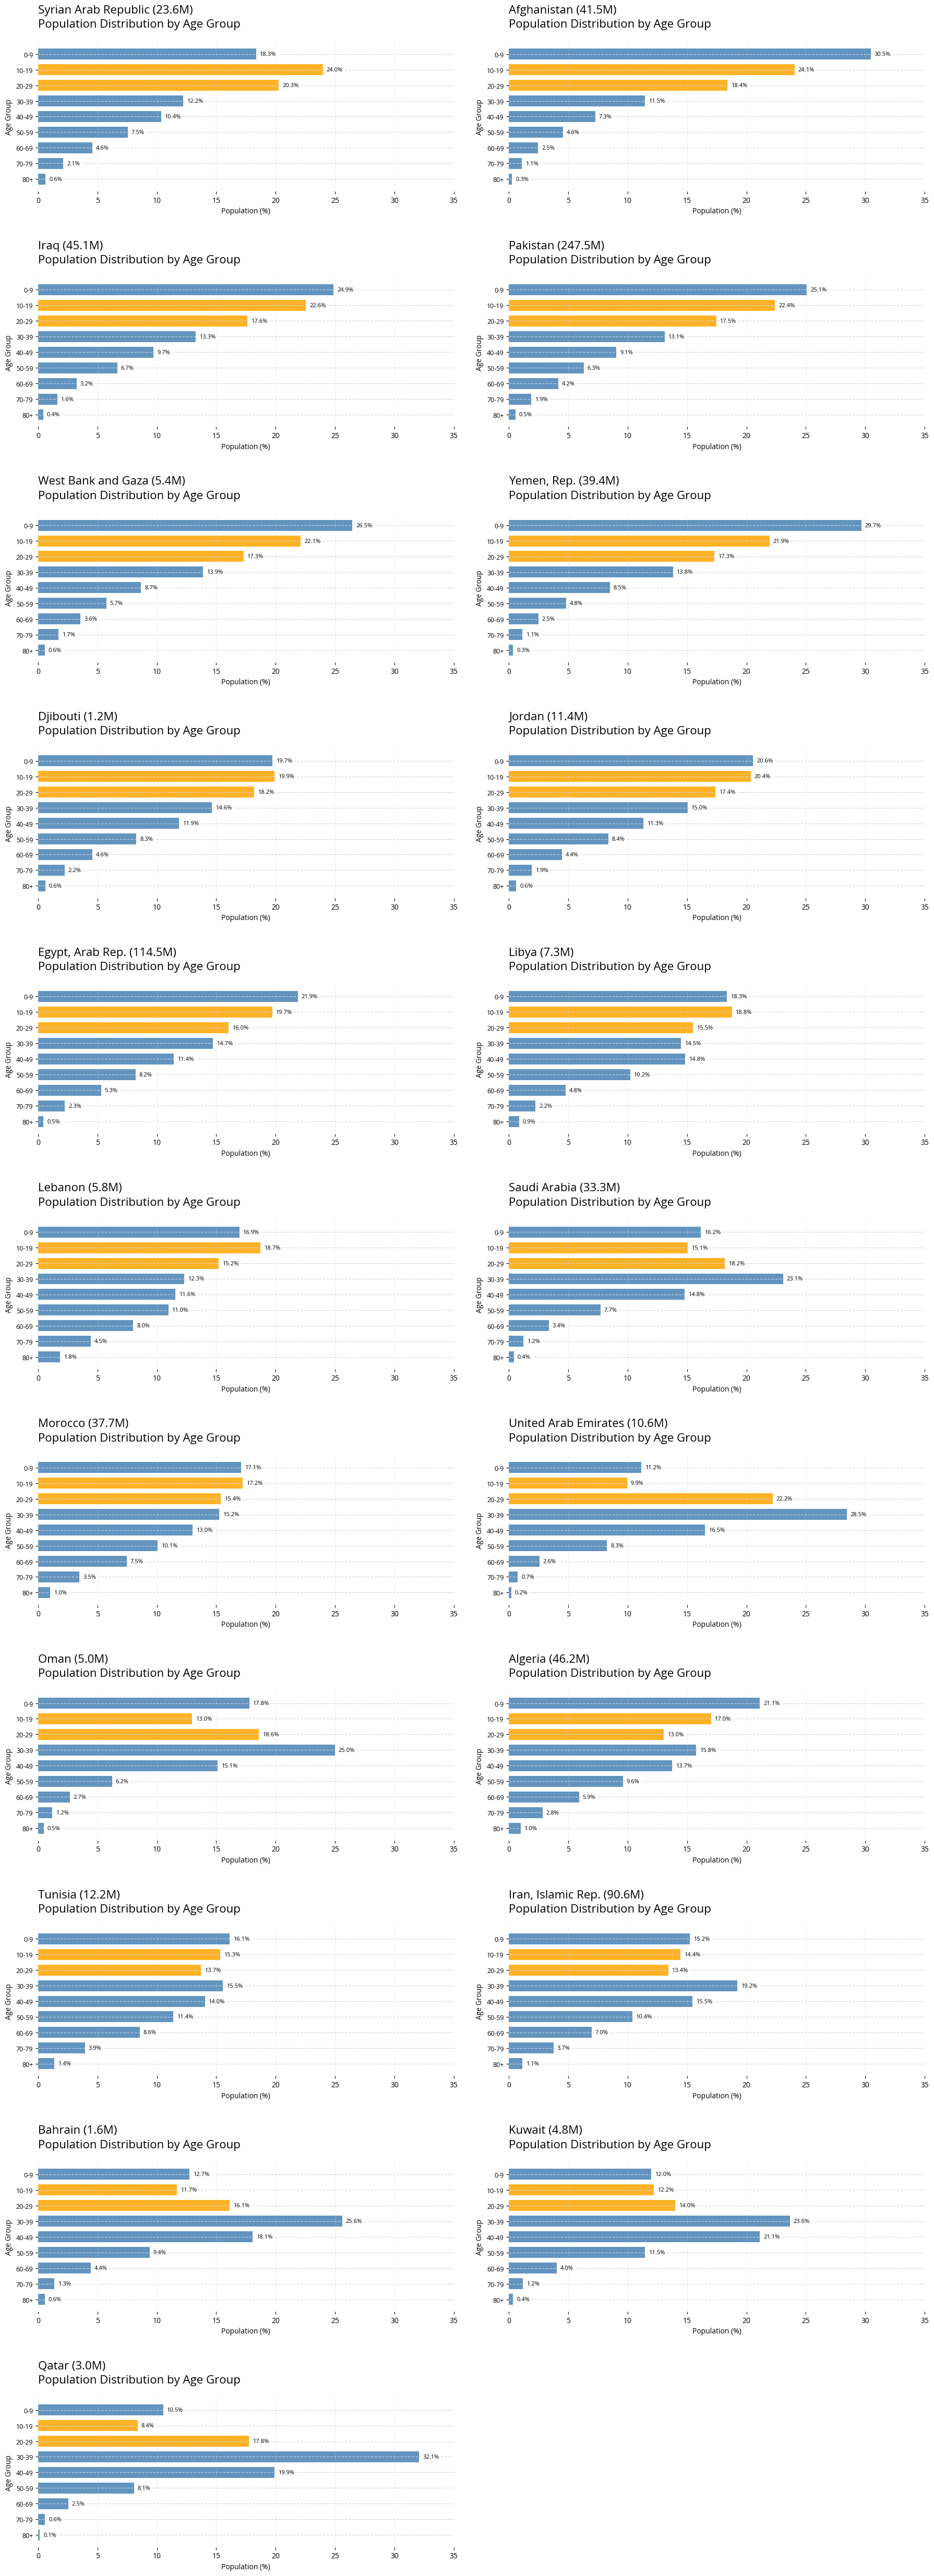

In [52]:

# Create subplots with 2 columns showing all countries sorted by Gen Z population
import numpy as np
import matplotlib.pyplot as plt

country_col = 'country_name'

# Calculate Gen Z percentage (10-19 + 20-29) as % of total population for sorting
df_grouped['gen_z_pct'] = ((df_grouped['10-19'] + df_grouped['20-29']) / 
                            (df_grouped[age_groups_10yr].sum(axis=1)) * 100)

# Sort by Gen Z percentage in descending order
df_sorted = df_grouped.sort_values('gen_z_pct', ascending=False)
countries = df_sorted[country_col].values
n_countries = len(countries)
n_rows = int(np.ceil(n_countries / 2))

# Create figure with subplots
fig, axes = plt.subplots(n_rows, 2, figsize=(18, 4.5 * n_rows))
axes = axes.flatten()

# Plot all countries
def plot_all_countries():
    for idx, country in enumerate(countries):
        ax = axes[idx]
        country_data = df_sorted[df_sorted[country_col] == country].iloc[0]
        
        # Prepare data
        total_pop = country_data[age_groups_10yr].sum()
        # Convert from thousands to actual population and format for display
        total_pop_millions = (total_pop * 1000) / 1_000_000
        if total_pop_millions >= 1:
            pop_display = f"{total_pop_millions:.1f}M"
        else:
            pop_display = f"{(total_pop * 1000) / 1000:.0f}K"
        
        pct_data = (country_data[age_groups_10yr] / total_pop * 100).values
        
        y_pos = np.arange(len(age_groups_10yr))
        
        # Define colors for each age group (orange for 10-19 and 20-29)
        colors = ['steelblue' if age not in ['10-19', '20-29'] else 'orange' 
                  for age in age_groups_10yr]
        
        # Create horizontal bar chart with custom colors
        bars = ax.barh(y_pos, pct_data, height=0.7, color=colors, alpha=0.85)
        
        # Customize the plot
        ax.set_yticks(y_pos)
        ax.set_yticklabels(age_groups_10yr, fontsize=9)
        ax.set_xlabel('Population (%)', fontsize=10)
        ax.set_ylabel('Age Group', fontsize=10)
        ax.invert_yaxis()  # Youngest at bottom
        ax.grid(axis='x', alpha=0.3, linestyle='--')
        
        # Set title with country name and total population in brackets
        ax.set_title(f'{country} ({pop_display})\nPopulation Distribution by Age Group', 
                     fontsize=16, fontweight='bold', pad=20, 
                     linespacing=1.4, loc='left')
        
        # Add percentage labels on bars with smart positioning to avoid overlap

        for i, (v, age) in enumerate(zip(pct_data, age_groups_10yr)):
            # Position text at the end of the bar with some padding
            x_pos = v + 0.3
            ax.text(x_pos, i, f'{v:.1f}%', va='center', fontsize=8, 
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='none'))
        
        # Set x-axis limits to a fixed 35% for all charts
        ax.set_xlim(0, 35)
    
    # Remove extra subplots if odd number of countries
    for idx in range(n_countries, len(axes)):
        axes[idx].axis('off')

plot_all_countries()

# Adjust layout with proper spacing to prevent overlap
plt.tight_layout(h_pad=3.5, w_pad=2.5)
#plt.savefig('../outputs/population_distribution_by_genz.png', dpi=300, bbox_inches='tight')
plt.show()
